<p style="font-size: 45px; text-align: center;"><b>Machine Learning in Finance II - final project</b></p>
<p style="font-size: 35px; text-align: center;"><b>Forecasting delays in delivery time - Brazilian E-commerce</b></p>
<p style="font-size: 20px; text-align: center;"><b>CatBoost - choosing the best model</b></p>

Author: Jakub Pyszniak

Notebook 5

# Analysis overview

> **In this section we will choose the best CatBoost (regressor) model to predict order delays**

> **We perform the necessary Cross-Validation**

# Libraries

In [50]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import math
import time
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

# Visual set-up
pd.set_option("display.max_columns", 60)

# CatBoost
from catboost import Pool, cv, CatBoostRegressor

# Loading data & choosing the best features

We can use the feature ranking from earlier to limit our feature ("X") set size from 30+ to 10 or 15 best

In [2]:
# These data will be used for CV and choosing the best models
df_train = pd.read_csv("4.train_and_test/df_train.csv")

# We will use this set to test the forecasting power of our best models (final comparisons)
df_test = pd.read_csv("4.train_and_test/df_test.csv")

# Our feature ranking dataset
fr = pd.read_excel("3.feature_ranking/feature_ranking.xlsx")

In [3]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     73180 non-null  float64
 1   order_item_id                  73180 non-null  int64  
 2   total_price                    73180 non-null  float64
 3   total_freight                  73180 non-null  float64
 4   order_value_check              73180 non-null  float64
 5   is_payment_sequential_1        73180 non-null  int64  
 6   payment_type_boleto            73180 non-null  int64  
 7   payment_type_credit_card       73180 non-null  int64  
 8   payment_type_debit_card        73180 non-null  int64  
 9   payment_type_voucher           73180 non-null  int64  
 10  installments_boleto            73180 non-null  int64  
 11  installments_credit_card       73180 non-null  int64  
 12  installments_debit_card        73180 non-null 

,delay_days,order_item_id,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_voucher,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state,customer_state,cust_sell_same_state,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_purchase_dow,order_delivery_dow,order_estimate_dow
0,-21.0,1,19.99,14.10,34.09,1,0,1,0,0,0,1,0,0,48.0,575.0,1,100.0,20.0,15.0,15.0,43,21,18,0,-22.761992,-43.450873,-23.665703,-46.518082,329.149657,6,6,5,0,0
1,-4.0,1,72.90,19.70,92.60,1,0,1,0,0,0,1,0,0,37.0,360.0,1,650.0,45.0,15.0,25.0,67,14,25,0,-21.679558,-49.762053,-23.179392,-50.634922,189.372236,8,8,0,3,0
2,-38.0,1,50.90,15.57,66.47,1,0,1,0,0,0,1,0,0,60.0,473.0,1,600.0,30.0,4.0,20.0,39,21,18,0,-22.449744,-43.474330,-21.766477,-48.831547,557.068979,2,2,3,4,0
3,-8.0,1,199.90,14.23,214.13,1,0,1,0,0,0,5,0,0,60.0,233.0,1,2600.0,41.0,8.0,36.0,7,21,25,1,-23.640572,-46.570773,-22.716839,-47.657366,151.282904,6,6,0,2,3
4,-12.0,2,44.00,35.26,79.26,1,0,1,0,0,0,7,0,0,58.0,1623.0,1,200.0,26.0,10.0,22.0,7,5,18,0,-22.983577,-43.220723,-16.692331,-49.268016,942.794225,3,3,4,2,0


In [4]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     18295 non-null  float64
 1   order_item_id                  18295 non-null  int64  
 2   total_price                    18295 non-null  float64
 3   total_freight                  18295 non-null  float64
 4   order_value_check              18295 non-null  float64
 5   is_payment_sequential_1        18295 non-null  int64  
 6   payment_type_boleto            18295 non-null  int64  
 7   payment_type_credit_card       18295 non-null  int64  
 8   payment_type_debit_card        18295 non-null  int64  
 9   payment_type_voucher           18295 non-null  int64  
 10  installments_boleto            18295 non-null  int64  
 11  installments_credit_card       18295 non-null  int64  
 12  installments_debit_card        18295 non-null 

,delay_days,order_item_id,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_voucher,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state,customer_state,cust_sell_same_state,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_purchase_dow,order_delivery_dow,order_estimate_dow
0,-15.0,1,108.0,16.52,124.52,1,0,1,0,0,0,1,0,0,58.0,3006.0,2,1000.0,53.0,8.0,18.0,72,15,10,0,-21.248980,-44.998179,-22.874599,-43.477731,239.212282,2,2,5,3,4
1,-2.0,1,78.0,7.80,85.80,1,0,1,0,0,0,2,0,0,59.0,319.0,4,250.0,16.0,2.0,20.0,72,21,25,1,-23.657047,-46.774874,-23.651115,-46.755211,2.108617,11,11,4,1,3
2,-19.0,1,199.9,15.15,215.05,1,0,1,0,0,0,5,0,0,55.0,623.0,1,337.0,16.0,13.0,13.0,72,21,18,0,-22.704280,-43.571287,-22.828655,-47.267296,379.200398,6,6,3,2,0
3,-17.0,1,69.0,19.45,88.45,1,0,1,0,0,0,6,0,0,51.0,324.0,1,900.0,42.0,8.0,37.0,7,21,18,0,-22.747569,-43.488349,-21.766477,-48.831547,560.549267,6,6,3,0,3
4,-5.0,1,44.9,9.42,54.32,1,1,0,0,0,1,0,0,0,51.0,1118.0,5,400.0,18.0,8.0,14.0,49,21,25,1,-23.663579,-46.617176,-23.198860,-47.293346,86.193580,3,3,3,3,1


In [5]:
fr.rename(columns={"Unnamed: 0": "feature"}, inplace=True)

fr = fr.sort_values(by=["boruta_rank","mi_score"], ascending=[True, False])

fr.info()
fr.head(40)

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 2 to 11
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   feature      34 non-null     object 
 1   mi_score     34 non-null     float64
 2   boruta_rank  34 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ KB


,feature,mi_score,boruta_rank
2,total_freight,0.071483,1
29,order_purchase_month,0.067143,1
30,order_delivery_month,0.063950,1
27,seller_lng,0.057679,1
28,cust_sell_distance_km,0.052569,1
24,customer_lat,0.046624,1
25,customer_lng,0.044898,1
23,cust_sell_same_state,0.043066,1
21,seller_state,0.020188,1
13,product_name_length,0.003299,1


In [6]:
fr = fr.set_index("feature")

We will create arrays with the best features so that we can pick them later from our dataframes

In [7]:
br10_feat = fr.iloc[0:10].index.tolist()
print("10 best:\n", br10_feat)

br15_feat = fr.iloc[0:15].index.tolist()
print("15 best:\n", br15_feat)

br20_feat = fr.iloc[0:20].index.tolist()
print("20 best:\n", br20_feat)

br25_feat = fr.iloc[0:25].index.tolist()
print("25 best:\n", br25_feat)

br30_feat = fr.iloc[0:30].index.tolist()
print("30 best:\n", br30_feat)

10 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'cust_sell_distance_km', 'customer_lat', 'customer_lng', 'cust_sell_same_state', 'seller_state', 'product_name_length']
15 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'cust_sell_distance_km', 'customer_lat', 'customer_lng', 'cust_sell_same_state', 'seller_state', 'product_name_length', 'product_width_cm', 'order_estimate_dow', 'product_weight_g', 'seller_lat', 'product_height_cm']
20 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'cust_sell_distance_km', 'customer_lat', 'customer_lng', 'cust_sell_same_state', 'seller_state', 'product_name_length', 'product_width_cm', 'order_estimate_dow', 'product_weight_g', 'seller_lat', 'product_height_cm', 'order_value_check', 'customer_state', 'product_description_length', 'total_price', 'order_delivery_dow']
25 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_mo

## X and y test/train

In [8]:
# build X / y splits using only the selected features

X10_train = df_train.loc[:, br10_feat].copy()
X15_train = df_train.loc[:, br15_feat].copy()
X20_train = df_train.loc[:, br20_feat].copy()
X25_train = df_train.loc[:, br25_feat].copy()
X30_train = df_train.loc[:, br30_feat].copy()
y_train = df_train.loc[:, "delay_days"].copy()

X10_test  = df_test.loc[:, br10_feat].copy()
X15_test  = df_test.loc[:, br15_feat].copy()
X20_test  = df_test.loc[:, br20_feat].copy()
X25_test  = df_test.loc[:, br25_feat].copy()
X30_test  = df_test.loc[:, br30_feat].copy()
y_test  = df_test.loc[:, "delay_days"].copy()

In [9]:
X10_train.info(), X15_train.info(), X20_train.info(), X25_train.info(), X30_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_freight          73180 non-null  float64
 1   order_purchase_month   73180 non-null  int64  
 2   order_delivery_month   73180 non-null  int64  
 3   seller_lng             73180 non-null  float64
 4   cust_sell_distance_km  73180 non-null  float64
 5   customer_lat           73180 non-null  float64
 6   customer_lng           73180 non-null  float64
 7   cust_sell_same_state   73180 non-null  int64  
 8   seller_state           73180 non-null  int64  
 9   product_name_length    73180 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 5.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0  

(None, None, None, None, None)

In [10]:
X10_test.info(), X15_test.info(), X20_test.info(), X25_test.info(), X30_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_freight          18295 non-null  float64
 1   order_purchase_month   18295 non-null  int64  
 2   order_delivery_month   18295 non-null  int64  
 3   seller_lng             18295 non-null  float64
 4   cust_sell_distance_km  18295 non-null  float64
 5   customer_lat           18295 non-null  float64
 6   customer_lng           18295 non-null  float64
 7   cust_sell_same_state   18295 non-null  int64  
 8   seller_state           18295 non-null  int64  
 9   product_name_length    18295 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0  

(None, None, None, None, None)

In [11]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 73180 entries, 0 to 73179
Series name: delay_days
Non-Null Count  Dtype  
--------------  -----  
73180 non-null  float64
dtypes: float64(1)
memory usage: 571.8 KB


In [12]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 18295 entries, 0 to 18294
Series name: delay_days
Non-Null Count  Dtype  
--------------  -----  
18295 non-null  float64
dtypes: float64(1)
memory usage: 143.1 KB


# Model selection

A standard GridSearchCV might be too taxing for a CatBoost model if we want to try out a variety of hyperparameters. We will use RandomizedSearchCV as a basis.

> Our RandomizedSearchCV set-up

In [ ]:
def cv_my_random_catboost_fast(
    X_train, y_train, X_test, y_test,
    param_distributions,
    n_iter=25,
    cv=3,
    random_state=42,
    show_results=True,
    cat_features=None,
    iterations_rs=700,     # cap training length during RS stage
    thread_count=1          # prevents oversubscription when n_jobs=-1
):
    start = time.perf_counter()

    cv_split = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    cb = CatBoostRegressor(
        loss_function="RMSE",
        random_seed=random_state,
        verbose=False,
        iterations=iterations_rs,
        thread_count=thread_count,
        allow_writing_files=False
    )

    fit_params = {}
    if cat_features is not None:
        fit_params["cat_features"] = cat_features

    search = RandomizedSearchCV(
        estimator=cb,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv_split,
        refit=True,
        return_train_score=True,
        n_jobs=-1,
        random_state=random_state,
        verbose=0
    )

    search.fit(X_train, np.asarray(y_train).ravel(), **fit_params)

    best_model = search.best_estimator_

    y_pred = best_model.predict(X_test)

    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae  = float(mean_absolute_error(y_test, y_pred))
    r2   = float(r2_score(y_test, y_pred))

    elapsed_sec = time.perf_counter() - start

    if show_results:
        print("Best params:", search.best_params_)
        print("Best CV RMSE:", -search.best_score_)
        print("TEST RMSE:", rmse)
        print("TEST MAE:", mae)
        print("TEST R²:", r2)
        print(f"Elapsed time: {elapsed_sec:.2f} seconds")

    return {
        "search": search,
        "best_model": best_model,
        "best_cv_rmse": -search.best_score_,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "elapsed_sec": elapsed_sec
    }


In [29]:
# Categorical columns choice
X10_test.info() # or train - the same features
X10_test.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_freight          18295 non-null  float64
 1   order_purchase_month   18295 non-null  int64  
 2   order_delivery_month   18295 non-null  int64  
 3   seller_lng             18295 non-null  float64
 4   cust_sell_distance_km  18295 non-null  float64
 5   customer_lat           18295 non-null  float64
 6   customer_lng           18295 non-null  float64
 7   cust_sell_same_state   18295 non-null  int64  
 8   seller_state           18295 non-null  int64  
 9   product_name_length    18295 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 1.4 MB


total_freight             3840
order_purchase_month        12
order_delivery_month        12
seller_lng                1522
cust_sell_distance_km    17995
customer_lat              8344
customer_lng              8344
cust_sell_same_state         2
seller_state                20
product_name_length         59
dtype: int64

**Different features**

In [ ]:
param_distributions = {
            "learning_rate": [0.01, 0.05, 0.1],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [1, 3, 5],
        "iterations": [200, 300, 700]                   
        }
# Takes extremely long with actual distributions

cat_features = ["order_purchase_month", "order_delivery_month", "seller_state" ]

catboost10vars_RS = cv_my_random_catboost_fast(
    X10_train, y_train, X10_test, y_test,
    param_distributions = param_distributions,
    n_iter=25,
    cv=3,
    random_state=42,
    show_results=False,
    cat_features=cat_features,
    iterations_rs=700,     # cap training length during RS stage
    thread_count=1          # prevents oversubscription when n_jobs=-1
)

In [39]:
print("Best params:", catboost10vars_RS["search"].best_params_)
print("Best CV RMSE:", -catboost10vars_RS["search"].best_score_)
print("TEST RMSE:", catboost10vars_RS["rmse"])
print("TEST MAE:", catboost10vars_RS["mae"])
print("TEST R²:", catboost10vars_RS["r2"])
print(f"Elapsed time: {catboost10vars_RS["elapsed_sec"]:.2f} seconds")


Best params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 700, 'depth': 6}
Best CV RMSE: 7.4718196225859375
TEST RMSE: 7.404972790158394
TEST MAE: 5.25651772483575
TEST R²: 0.4884624260408935
Elapsed time: 589.58 seconds


We see that the model took quite a while. 

In [42]:
X15_test.nunique()

total_freight             3840
order_purchase_month        12
order_delivery_month        12
seller_lng                1522
cust_sell_distance_km    17995
customer_lat              8344
customer_lng              8344
cust_sell_same_state         2
seller_state                20
product_name_length         59
product_width_cm            85
order_estimate_dow           5
product_weight_g          1271
seller_lat                1522
product_height_cm           97
dtype: int64

In [43]:
cat_features = ["order_purchase_month", "order_delivery_month", "seller_state", "order_estimate_dow" ]

catboost15vars_RS = cv_my_random_catboost_fast(
    X15_train, y_train, X15_test, y_test,
    param_distributions = param_distributions,
    n_iter=25,
    cv=3,
    random_state=42,
    show_results=True,
    cat_features=cat_features,
    iterations_rs=700,     # cap training length during RS stage
    thread_count=1          # prevents oversubscription when n_jobs=-1
)

Best params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 700, 'depth': 6}
Best CV RMSE: 7.390319790319569
TEST RMSE: 7.332325318514686
TEST MAE: 5.191792350884754
TEST R²: 0.498450206281708
Elapsed time: 1009.38 seconds


We see an improvement!

In [44]:
X20_test.nunique()

total_freight                  3840
order_purchase_month             12
order_delivery_month             12
seller_lng                     1522
cust_sell_distance_km         17995
customer_lat                   8344
customer_lng                   8344
cust_sell_same_state              2
seller_state                     20
product_name_length              59
product_width_cm                 85
order_estimate_dow                5
product_weight_g               1271
seller_lat                     1522
product_height_cm                97
order_value_check             10651
customer_state                   27
product_description_length     2224
total_price                    2952
order_delivery_dow                7
dtype: int64

In [45]:
cat_features = ["order_purchase_month", "order_delivery_month", "seller_state", "order_estimate_dow",
                "customer_state", "order_delivery_dow" ]

catboost20vars_RS = cv_my_random_catboost_fast(
    X20_train, y_train, X20_test, y_test,
    param_distributions = param_distributions,
    n_iter=25,
    cv=3,
    random_state=42,
    show_results=True,
    cat_features=cat_features,
    iterations_rs=700,     # cap training length during RS stage
    thread_count=1          # prevents oversubscription when n_jobs=-1
)

Best params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 700, 'depth': 6}
Best CV RMSE: 7.36006270683869
TEST RMSE: 7.319500982280996
TEST MAE: 5.178836173310321
TEST R²: 0.5002031067731931
Elapsed time: 979.54 seconds


In [46]:
X25_test.nunique()

total_freight                     3840
order_purchase_month                12
order_delivery_month                12
seller_lng                        1522
cust_sell_distance_km            17995
customer_lat                      8344
customer_lng                      8344
cust_sell_same_state                 2
seller_state                        20
product_name_length                 59
product_width_cm                    85
order_estimate_dow                   5
product_weight_g                  1271
seller_lat                        1522
product_height_cm                   97
order_value_check                10651
customer_state                      27
product_description_length        2224
total_price                       2952
order_delivery_dow                   7
product_category_name_english       70
order_purchase_dow                   7
product_length_cm                   96
installments_credit_card            19
product_photos_qty                  18
dtype: int64

In [47]:
cat_features = ["order_purchase_month", "order_delivery_month", "seller_state", "order_estimate_dow",
                "customer_state", "order_delivery_dow", "product_category_name_english", "order_purchase_dow"]

catboost25vars_RS = cv_my_random_catboost_fast(
    X25_train, y_train, X25_test, y_test,
    param_distributions = param_distributions,
    n_iter=25,
    cv=3,
    random_state=42,
    show_results=True,
    cat_features=cat_features,
    iterations_rs=700,     # cap training length during RS stage
    thread_count=1          # prevents oversubscription when n_jobs=-1
)

Best params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 700, 'depth': 6}
Best CV RMSE: 7.321794447668762
TEST RMSE: 7.263960627567329
TEST MAE: 5.139599877351021
TEST R²: 0.5077592447074247
Elapsed time: 1315.65 seconds


Even better!

In [48]:
X30_test.nunique()

total_freight                     3840
order_purchase_month                12
order_delivery_month                12
seller_lng                        1522
cust_sell_distance_km            17995
customer_lat                      8344
customer_lng                      8344
cust_sell_same_state                 2
seller_state                        20
product_name_length                 59
product_width_cm                    85
order_estimate_dow                   5
product_weight_g                  1271
seller_lat                        1522
product_height_cm                   97
order_value_check                10651
customer_state                      27
product_description_length        2224
total_price                       2952
order_delivery_dow                   7
product_category_name_english       70
order_purchase_dow                   7
product_length_cm                   96
installments_credit_card            19
product_photos_qty                  18
payment_type_credit_card 

In [49]:
cat_features = ["order_purchase_month", "order_delivery_month", "seller_state", "order_estimate_dow",
                "customer_state", "order_delivery_dow", "product_category_name_english", "order_purchase_dow"]
# No new categorical features

catboost30vars_RS = cv_my_random_catboost_fast(
    X30_train, y_train, X30_test, y_test,
    param_distributions = param_distributions,
    n_iter=25,
    cv=3,
    random_state=42,
    show_results=True,
    cat_features=cat_features,
    iterations_rs=700,     # cap training length during RS stage
    thread_count=1          # prevents oversubscription when n_jobs=-1
)

Best params: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 700, 'depth': 6}
Best CV RMSE: 7.329933222352402
TEST RMSE: 7.26219286243081
TEST MAE: 5.131424260319081
TEST R²: 0.5079988000156992
Elapsed time: 2319.30 seconds


> We got a slight improvement! Let's choose this model

# Pool & early stopping | CatBoost native cv

We can advantage of some CatBoost native objects to fine-tune our model

Training on fold [0/5]

bestTest = 7.174789391
bestIteration = 2251

Training on fold [1/5]

bestTest = 7.169835527
bestIteration = 2031

Training on fold [2/5]

bestTest = 7.484698126
bestIteration = 2339

Training on fold [3/5]

bestTest = 7.026760174
bestIteration = 1904

Training on fold [4/5]

bestTest = 6.939823908
bestIteration = 1892

Best iteration (from CatBoost cv): 2340
Best CV RMSE (CatBoost cv): 7.160028953447222


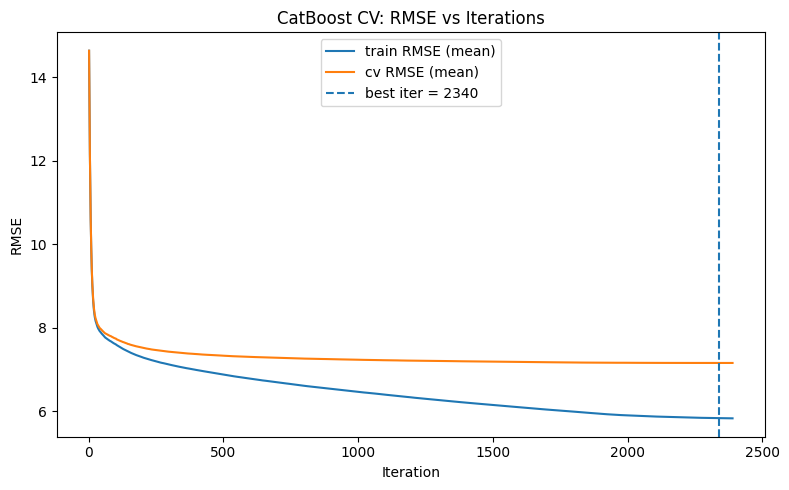

FINAL TEST RMSE: 7.108677416972066
FINAL TEST MAE: 5.0179091391864
FINAL TEST R²: 0.5285797658504626


In [51]:
# ============================================================
# 0) Set your objects / data
# ============================================================

cb_rs = catboost30vars_RS

# ============================================================
# 1) Identify categorical features and build Pools
# ============================================================

cat_features = ["order_purchase_month", "order_delivery_month", "seller_state", "order_estimate_dow",
                "customer_state", "order_delivery_dow", "product_category_name_english", "order_purchase_dow"]

train_pool = Pool(X30_train, label=np.asarray(y_train).ravel(), cat_features=cat_features)
test_pool  = Pool(X30_test,  label=np.asarray(y_test).ravel(),  cat_features=cat_features)


# ============================================================
# 2) Pull best hyperparams from RandomizedSearchCV and adapt for native CV
#    - In CatBoost, "iterations" is what we'll tune via cv (like boosting rounds)
# ============================================================
best_params = cb_rs["search"].best_params_   # <-- change cb_rs to your CatBoost random-search result dict

params = dict(best_params)
params.pop("iterations", None)  # cv will control iterations
params.update({
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": 42,
    "verbose": False
})


# ============================================================
# 3) Native CatBoost CV with early stopping
#    - iterations: high cap
#    - early stopping: overfitting detector (od_type/od_wait)
# ============================================================
nfold = 5
max_iterations = 5000

# CatBoost early stopping uses od_type + od_wait
# (od_wait is roughly like early_stopping_rounds patience)
params.setdefault("od_type", "Iter")
params.setdefault("od_wait", 50)

cv_results = cv(
    pool=train_pool,
    params=params,
    fold_count=nfold,
    iterations=max_iterations,
    shuffle=True,
    partition_random_seed=42,
    verbose=False
)

# cv_results is a pandas DataFrame with columns like:
# 'test-RMSE-mean', 'test-RMSE-std', 'train-RMSE-mean', 'train-RMSE-std'
test_rmse_mean = cv_results["test-RMSE-mean"].to_numpy()
best_iter = int(np.argmin(test_rmse_mean) + 1)
best_cv_rmse = float(np.min(test_rmse_mean))

print("Best iteration (from CatBoost cv):", best_iter)
print("Best CV RMSE (CatBoost cv):", best_cv_rmse)


# ============================================================
# 4) Plot CV loss vs iterations + vertical line at best iteration
# ============================================================
iters = np.arange(1, len(test_rmse_mean) + 1)

plt.figure(figsize=(8, 5))
plt.plot(iters, cv_results["train-RMSE-mean"], label="train RMSE (mean)")
plt.plot(iters, cv_results["test-RMSE-mean"],  label="cv RMSE (mean)")
plt.axvline(best_iter, linestyle="--", label=f"best iter = {best_iter}")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("CatBoost CV: RMSE vs Iterations")
plt.legend()
plt.tight_layout()
plt.show()


# ============================================================
# 5) Refit final CatBoost model on FULL training set using best_iter
# ============================================================
final_params = dict(params)
final_params["iterations"] = best_iter
final_params["verbose"] = False

final_cb = CatBoostRegressor(**final_params)
final_cb.fit(train_pool)

# ============================================================
# 6) Evaluate on test set (unseen)
# ============================================================
y_pred = final_cb.predict(test_pool)

rmse_test = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae_test  = float(mean_absolute_error(y_test, y_pred))
r2_test   = float(r2_score(y_test, y_pred))

print("FINAL TEST RMSE:", rmse_test)
print("FINAL TEST MAE:", mae_test)
print("FINAL TEST R²:", r2_test)

> **We end up with an even better model than our XGBoost!**

# Saving the best CatBoost model

In [ ]:
model_path = "5.models/catboost30vars_final_cb.pkl"
with open(model_path, "wb") as f:
    pickle.dump(final_cb, f)

print("Saved final CatBoost model to:", model_path)

Saved final CatBoost model to: 5.models/catboost30vars_final_cb.pkl


In [ ]:
X30_train.to_pickle("6.data_cache/X30_train.pkl")
X30_test.to_pickle("6.data_cache/X30_test.pkl")